# Getting Google Drive Files
LTO puts data files out on Google drive. Getting them in to a Python workspace can be tricky. Here, we'll deal with Google authorization and the various gyrations in order to get data files into Pandas.

In [2]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
#from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

## Client Secrets
Google authoriztion requires a client secret file -- this helps ensure the client (me) is actually authorized to access the content in question. Through the Google API Console, one creates a client and can then download a file called client_id.

Previously, we worked on the Utah Oil and Gas project which downloaded content from a Google drive. This application had a file client_secrets in the current directory.  The authorization didn't work without this file.

A comparison of the `client_id` json file downloaded from the Google API Console to `client_secrets` from the Utah project shows the two to be very similar in structure and values. The `project_id` and `client_id` fields differ in that they are values from their respective projects.

So it would appear that I can rename the client_id file as client_secrets.json for purposes of authentication and authorization.

## Get File Names from a Google Drive Directory

Here are two routines that together return a list of file names or a list of Google file ojects from a Google Drive folder.  The former is useful when seeing what files are in the directory; the latter when neeeding to obtain the contents of one or more files on the Google Drive.

In [3]:
#ripped and modified from Utah project
def get_files(slug, files=False):
    """
    returns a list of files from a google drive folder, recurses down into sub-dirs
    Parameters:
        slug: id of the directory
        files: True => return file objects, False => return file names
    Returns:
        List of file names or file objects in the directory
    """
    gauth = GoogleAuth()
    # Try to load saved client credentials
    gauth.LoadCredentialsFile("mycreds.txt")
    if gauth.credentials is None:
        # Authenticate if they're not there
        gauth.LocalWebserverAuth()
    elif gauth.access_token_expired:
        os.remove('mycreds.txt')
        gauth.LocalWebserverAuth()
    else:
        # Initialize the saved creds
        gauth.Authorize()
    # Save the current credentials to a file
    gauth.SaveCredentialsFile("mycreds.txt")

    drive = GoogleDrive(gauth)

    return list_folder(slug, drive, files=files)



In [4]:
def list_folder(parent, drive, is_top=True, files=False):
    try:
        file_list = drive.ListFile(
            {'q': "'{}' in parents and trashed=false".format(
                parent)}).GetList()
        fids = []
        for f in file_list:
            if f['mimeType'] == 'application/vnd.google-apps.folder':
                fids = fids + list_folder(f['id'], drive, is_top=False, files=files)
            else:
                if files:
                    fids.append(f)
                else:
                    fids.append(f['title'])
        return (fids)

    except Exception as e:
        print(e)


Directory supplied by Terry: (https://drive.google.com/drive/folders/1pt_P1YZc71rF0sH2rve24Td2vpCVnjrZ?usp=sharing). The HI data is in a dirctory: https://drive.google.com/drive/folders/14JRb6XKdILOPhrZiGvKfRmKYvFfFsPfo

So I think the directory Id is the crazy number at the end.

In [5]:
dir_id = '14JRb6XKdILOPhrZiGvKfRmKYvFfFsPfo'
file_list = get_files(dir_id)

C:\Users\kevin\Anaconda3\lib\site-packages\oauth2client\_helpers.py:255: UserWarning: Cannot access mycreds.txt: No such file or directory
  warnings.warn(_MISSING_FILE_MESSAGE.format(filename))


In [6]:
len(file_list)

1418

In [7]:
file_list[0]

'LTO-HI-2018-08-30-00-00-00_1420397kHz.fft'

In [8]:
file_list[1]

'LTO-HI-2018-08-30-00-01-03_1420397kHz.fft'

In [9]:
file_list=get_files(dir_id, files=True)

In [10]:
file_list[3]['title']

'LTO-HI-2018-08-30-00-03-06_1420397kHz.fft'

## Get File Contents

The `GetContentString` gets the file contents and returns it as a string

In [11]:
str=file_list[3].GetContentString()

In [12]:
len(str)

1868375

World's longest string!

In [13]:
str[0:400]

'#            Date  2018     8    30\n#            Time     0     3     6\n#          NBYTES          2\n#        NSAMPLES  493551616\n#          LENFFT      16384\n#          NUMAVE    9999999\n#          Period      0.00163840\n#          Center    1420397000.0\n#              dF    610.35156250\n#              dT     49.35515976\n#              ST      0.00000010\n#              FS      0.00001000\n#       '

## Create a Pandas Data Frame from File Contents
Panda's `read_csv` method takes a string containing a path name or something that has a `read()` method.  StringIO makes a string kinda sorta act like a file, and provides a `read()` method and thus acceptable first argument to `pandas.read_csv`

In [14]:
from io import StringIO
import pandas as pd

In [15]:
# string to file
strio = StringIO(str)

In [16]:
type(strio)

_io.StringIO

In [17]:
strio.close()

In [18]:
colnames = ['Spec', 'Line', 'YMD', 'HMS', 'Sec', 'dF', 'F','PWR', 'PWR_dBm']

Just read it up as if it were a regular file:

In [19]:
strio=StringIO(str)
df = pd.read_csv(strio, names = colnames, header=None,  delim_whitespace=True,
                 skiprows=16)
strio.close()


In [20]:
len(df)

16384

In [21]:
df.head()

,Spec,Line,YMD,HMS,Sec,dF,F,PWR,PWR_dBm
0,1,-8192,2018-08-30,00:03:06,30.678,-5000.00000,1.415397e+06,1.000000,0.000
1,1,-8191,2018-08-30,00:03:06,30.678,-4999.38965,1.415398e+06,1.000000,0.000
2,1,-8190,2018-08-30,00:03:06,30.678,-4998.77930,1.415398e+06,0.538561,-2.688
3,1,-8189,2018-08-30,00:03:06,30.678,-4998.16895,1.415399e+06,0.540211,-2.674
4,1,-8188,2018-08-30,00:03:06,30.678,-4997.55859,1.415399e+06,0.545013,-2.636


In [22]:
df.tail()

,Spec,Line,YMD,HMS,Sec,dF,F,PWR,PWR_dBm
16379,1,8187,2018-08-30,00:03:06,30.678,4996.94824,1.425394e+06,0.717369,-1.443
16380,1,8188,2018-08-30,00:03:06,30.678,4997.55859,1.425395e+06,0.723902,-1.403
16381,1,8189,2018-08-30,00:03:06,30.678,4998.16895,1.425395e+06,0.730658,-1.363
16382,1,8190,2018-08-30,00:03:06,30.678,4998.77930,1.425396e+06,0.685376,-1.641
16383,1,8191,2018-08-30,00:03:06,30.678,4999.38965,1.425396e+06,1.000000,0.000


## Function to Do It All!

In [23]:
def get_data(f):
    """
    Returns a data frame from the contents of a file
    Parameters:
        f: Google drive file
    
    """
    
    # read the file contents into a string
    fstr = f.GetContentString()
    
    # make it look like a file and read it into a dataframe
    colnames = ['Spec', 'Line', 'YMD', 'HMS', 'Sec', 'dF', 'F','PWR', 'PWR_dBm']
    with StringIO(fstr) as strio:
        df = pd.read_csv(strio, names = colnames, header=None,  delim_whitespace=True,
                 skiprows=16)   
    
    return df

In [24]:
df2 = get_data(file_list[300])

In [25]:
df2.head()

,Spec,Line,YMD,HMS,Sec,dF,F,PWR,PWR_dBm
0,1,-8192,2018-08-30,05:05:47,71.674,-5000.00000,1.415397e+06,1.000000,0.000
1,1,-8191,2018-08-30,05:05:47,71.674,-4999.38965,1.415398e+06,1.000000,0.000
2,1,-8190,2018-08-30,05:05:47,71.674,-4998.77930,1.415398e+06,0.571842,-2.427
3,1,-8189,2018-08-30,05:05:47,71.674,-4998.16895,1.415399e+06,0.573207,-2.417
4,1,-8188,2018-08-30,05:05:47,71.674,-4997.55859,1.415399e+06,0.575545,-2.399


In [26]:
file_list[300]['title']

'LTO-HI-2018-08-30-05-05-47_1420397kHz.fft'

## Pickling
Pickling serializes a Python object and optionally writes it to disk with or without compression.
See [Python Pickle Tutorial](https://www.datacamp.com/community/tutorials/pickle-python-tutorial). Let's pickle and unpickle df2

In [27]:
import pickle

In [28]:
fout = 'data/df2.out'
with open(fout, 'wb') as f:
    pickle.dump(df2,f)

In [29]:
fin = fout
with open(fin, 'rb') as f:
    df3 = pickle.load(f)

In [30]:
df3.head()

,Spec,Line,YMD,HMS,Sec,dF,F,PWR,PWR_dBm
0,1,-8192,2018-08-30,05:05:47,71.674,-5000.00000,1.415397e+06,1.000000,0.000
1,1,-8191,2018-08-30,05:05:47,71.674,-4999.38965,1.415398e+06,1.000000,0.000
2,1,-8190,2018-08-30,05:05:47,71.674,-4998.77930,1.415398e+06,0.571842,-2.427
3,1,-8189,2018-08-30,05:05:47,71.674,-4998.16895,1.415399e+06,0.573207,-2.417
4,1,-8188,2018-08-30,05:05:47,71.674,-4997.55859,1.415399e+06,0.575545,-2.399


The pickled file `df2.out` is about 1/2 the size on disk as the .fft file from whence it came. Let's compress and see what happens.

In [31]:
import bz2
import pickle

with bz2.BZ2File('data/df2.small', 'w') as sfile:
    pickle.dump(df2, sfile)

In [32]:
with bz2.BZ2File('data/df2.small', 'r') as sfile:
    df4 = pickle.load(sfile)

In [33]:
df4.head()

,Spec,Line,YMD,HMS,Sec,dF,F,PWR,PWR_dBm
0,1,-8192,2018-08-30,05:05:47,71.674,-5000.00000,1.415397e+06,1.000000,0.000
1,1,-8191,2018-08-30,05:05:47,71.674,-4999.38965,1.415398e+06,1.000000,0.000
2,1,-8190,2018-08-30,05:05:47,71.674,-4998.77930,1.415398e+06,0.571842,-2.427
3,1,-8189,2018-08-30,05:05:47,71.674,-4998.16895,1.415399e+06,0.573207,-2.417
4,1,-8188,2018-08-30,05:05:47,71.674,-4997.55859,1.415399e+06,0.575545,-2.399


The file `df2.small` is about 300 kb, versus 1.8 mb for the original `.fft` file, a reduction of a factor of 6.

In [34]:
len(df4)

16384

## Get, Pickle and Compress All of the Files

In [35]:
len(file_list)

1418

In [36]:
file_list[0]['title'].split(sep='[-_]')

['LTO-HI-2018-08-30-00-00-00_1420397kHz.fft']

In [37]:
import re

In [38]:
re.split('-|_|',file_list[0]['title'])

C:\Users\kevin\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


['LTO', 'HI', '2018', '08', '30', '00', '00', '00', '1420397kHz.fft']

In [41]:
re.split('-|_|',file_list[0]['title'])[2:8]

C:\Users\kevin\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


['2018', '08', '30', '00', '00', '00']

In [42]:
'data/'+'-'.join(re.split('-|_|',file_list[0]['title'])[2:8])+'.pcl'

C:\Users\kevin\Anaconda3\lib\re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


'data/2018-08-30-00-00-00.pcl'

Keep this coded commented out unless you have about 20 minutes.

In [43]:


#for f in file_list:
#    fout = 'data/'+'-'.join(re.split('-|_|',f['title'])[2:8])+'.pcl'
#    df = get_data(f)
#    with bz2.BZ2File(fout, 'w') as sfile:
#        pickle.dump(df2, sfile)

In [44]:
['a','b','c'][-1:3]

['c']

In [45]:
file_list[-1]['title']

'plot_3D.sh'

In [46]:
for f in file_list[-10:]:
    print (f['title'])

LTO-HI-2018-08-30-23-53-01_1420397kHz.fft
LTO-HI-2018-08-30-23-54-03_1420397kHz.fft
LTO-HI-2018-08-30-23-55-04_1420397kHz.fft
LTO-HI-2018-08-30-23-56-06_1420397kHz.fft
LTO-HI-2018-08-30-23-57-06_1420397kHz.fft
LTO-HI-2018-08-30-23-58-08_1420397kHz.fft
LTO-HI-2018-08-30-23-59-10_1420397kHz.fft
LTO-HI-2018-08-30.FFT
LTO-HI-2018-08-30.png
plot_3D.sh


In [47]:
len(file_list[0:-3])

1415

In [48]:
file_list[-2]['title']

'LTO-HI-2018-08-30.png'

In [53]:
fout = 'images/' +file_list[-2]['title']

In [54]:
fout

'images/LTO-HI-2018-08-30.png'

In [55]:
file_list[-2].GetContentFile(fout)

In [56]:
import Image

image = Image.open(fout)
image.show()

ModuleNotFoundError: No module named 'Image'

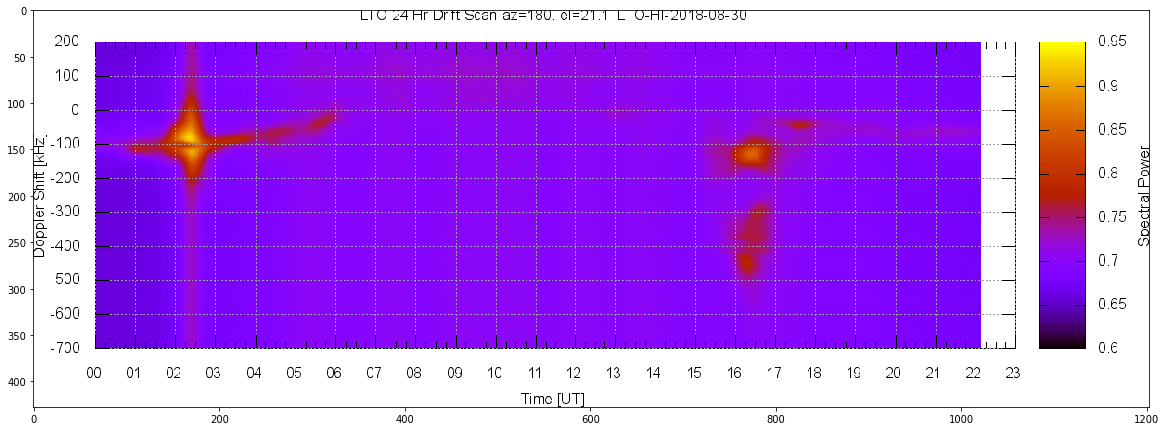

In [61]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams, cm

rcParams['figure.figsize'] = [20.0, 20.0]

img=mpimg.imread(fout)
imgplot = plt.imshow(img)
plt.show()

![Some Title](images/LTO-HI-2018-08-30.png)